## Deep Learning Lab.

In this lab we will continue working with the CIFAR-10 dataset. However, we will go deeper. Adding linear layers and non-linear activations functions on top of each other. First, I will present a re-implementation of what we had last time.

### 1. Implementing our own Softmax + CrossEntropyLoss function.
This is similar to the loss_softmax and loss_softmax_backward implementations in the previous lab. Here we also make sure this works for a batch of vectors instead of a single vector. This means the input here will be a tensor of size batchSize x inputSize:

In [23]:
import torch, lab_utils, random
from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os as os
from PIL import Image
import json, string
%matplotlib inline

In [34]:
# This class combines Softmax + Cross Entropy Loss.
# Similar to the previous lab, but this implementation works for batches of inputs and
# not just individual input vectors. Here the input is batchSize x inputSize.
class nn_CrossEntropyLoss(object): 
    # Forward pass -log softmax(input_{label})
    def forward(self, inputs, labels):
        max_val = inputs.max()  # This is to avoid variable overflows.
        exp_inputs = (inputs - max_val).exp()
        # This is different than in the previous lab. Avoiding for loops here.
        denominators = exp_inputs.sum(1).repeat(inputs.size(1), 1).t()
        self.predictions = torch.mul(exp_inputs, 1 / denominators)
        # Check what gather does. Just avoiding another for loop.
        return -self.predictions.log().gather(1, labels.view(-1, 1)).mean()
    
    # Backward pass 
    def backward(self, inputs, labels):
        grad_inputs = self.predictions.clone()
        # Ok, Here we will use a for loop (but it is avoidable too).
        for i in range(0, inputs.size(0)):
            grad_inputs[i][labels[i]] = grad_inputs[i][labels[i]] - 1
        return grad_inputs 

# Input: 4 vectors of size 10.
testInput = torch.Tensor(4, 10).normal_(0, 0.1)
# labels: 4 labels indicating the correct class for each input.
labels = torch.LongTensor([3, 4, 4, 8])

# Forward and Backward passes:
loss_softmax = nn_CrossEntropyLoss()
loss = loss_softmax.forward(testInput, labels)
gradInputs = loss_softmax.backward(testInput, labels)

Before continuing, make sure you understand every line of code in the above implementation by looking at previous lecture notes. 

### 2. Implementing our own Linear layer.
Next we provide an implementation for a linear layer that is also meant to work on batches of vetors. Notice that in addition of computing gradWeight and gradBias, we require here gradInput as we might need this gradient to do backpropagation. Making a batched implementation of this layer is easier because the only change is that now we have matrix-matrix multiplications as opposed to vector-matrix multiplications.

In [35]:
class nn_Linear(object):
    def __init__(self, inputSize, outputSize):
        self.weight = torch.Tensor(inputSize, outputSize).normal_(0, 0.01)
        self.gradWeight = torch.Tensor(inputSize, outputSize)
        self.bias = torch.Tensor(outputSize).zero_()
        self.gradBias = torch.Tensor(outputSize)
    
    # Forward pass, inputs is a matrix of size batchSize x inputSize
    def forward(self, inputs):
        # This one needs no change, it just becomes matrix x matrix multiplication
        # as opposed to just vector x matrix multiplication as we had before.
        return torch.matmul(inputs, self.weight) + self.bias
    
    # Backward pass, in addition to compute gradients for the weight and bias.
    # It has to compute gradients with respect to inputs. 
    def backward(self, inputs, gradOutput):
        self.gradWeight = torch.matmul(inputs.t(), gradOutput)
        self.gradBias = gradOutput.sum(0)
        return torch.matmul(gradOutput, self.weight.t())

# Input: 4 vectors of size 3072.
testInput = torch.Tensor(4, 3 * 32 * 32).normal_(0, 0.1)
dummyGradOutputs = torch.Tensor(4, 10).normal_(0, 0.1)

#Forward and Backward passes:
linear = nn_Linear(3 * 32 * 32, 10)
output = linear.forward(testInput)
gradInput = linear.backward(testInput, dummyGradOutputs)

### 3. Implementing an "Activation" function, or non-linearity.
Finally we need to implement some non-linear activation function. Here we will implement ReLU which is the simplest activation function but also one of the most important as we discussed during class.

In [36]:
class nn_ReLU(object):
    # pytorch has an element-wise max function.
    def forward(self, inputs):
        outputs = inputs.clone()
        outputs[outputs < 0] = 0
        return outputs
    
    # Make sure the backward pass is absolutely clear.
    def backward(self, inputs, gradOutput):
        gradInputs = gradOutput.clone()
        gradInputs[inputs < 0] = 0
        return gradInputs

### 4. Implementation I: CIFAR-10 Neural network classification using our implementations.
Ok, now we are ready to use our three layers to build a neural network. We will use it to classify images on CIFAR-10 as in our previous lab, but additionally we will use pytorch's DataLoaders which will build batches automatically for us, and will shuffle the data for us.

In [37]:
# In addition to transforming the image into a tensor, we also normalize the values in the image
# so that the mean pixel value is subtracted and divided by the pixel standard deviation.
imgTransform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010)),
                                   transforms.Lambda(lambda inputs: inputs.view(3 * 32 * 32))])
trainset = CIFAR10(root='./data', train = True, transform = imgTransform, download=True)
valset = CIFAR10(root='./data', train = False, transform = imgTransform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 128, 
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 128, 
                                        shuffle = False, num_workers = 0)

Files already downloaded and verified


Now that the dataset train, and validation splits are loaded, let's train.

In [ ]:
from tqdm import tqdm_notebook as tqdm

learningRate = 1e-4  # Single learning rate for this lab.

# Definition of our network.
linear1 = nn_Linear(3 * 32 * 32, 1024)
relu = nn_ReLU()
linear2 = nn_Linear(1024, 10)
criterion = nn_CrossEntropyLoss()

# Training loop.
for epoch in range(0, 10):
    correct = 0.0
    cum_loss = 0.0
    counter = 0.0
    # Make a pass over the training data.
    t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
    for (i, (inputs, labels)) in enumerate(t):
        # Forward pass:
        a = linear1.forward(inputs)
        b = relu.forward(a)
        c = linear2.forward(b)
        cum_loss += criterion.forward(c, labels)
        max_scores, max_labels = c.max(1)
        correct += (max_labels == labels).sum()
        
        # Backward pass:
        grads_c = criterion.backward(c, labels)
        grads_b = linear2.backward(b, grads_c)
        grads_a = relu.backward(a, grads_b)
        linear1.backward(inputs, grads_a)
        
        # Weight and bias updates.
        linear1.weight = linear1.weight - learningRate * linear1.gradWeight
        linear1.bias = linear1.bias - learningRate * linear1.gradBias
        linear2.weight = linear2.weight - learningRate * linear2.gradWeight
        linear2.bias = linear2.bias - learningRate * linear2.gradBias
        
        # logging information.
        counter += inputs.size(0)
        t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    counter = 0.0
    t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
    for (i, (inputs, labels)) in enumerate(t):
        
        # Forward pass:
        a = linear1.forward(inputs)
        b = relu.forward(a)
        c = linear2.forward(b)
        cum_loss += criterion.forward(c, labels)
        max_scores, max_labels = c.max(1)
        correct += (max_labels == labels).sum()
        
        # logging information.
        counter += inputs.size(0)
        t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

### 5. Implementation II: CIFAR-10 neural network classification using pytorch's nn functions.
Pytorch already comes with an impressive number of operations used to implement deep neural networks. Here we will use the same ones that we already have implemented and show how similar and easy is to use pytorch's implementations. Another thing about pytorch is that we will wrap our variables in a neural network with a torch.autograd.Variable object.

In [ ]:
from tqdm import tqdm_notebook as tqdm

learningRate = 1e-2  # Single learning rate for this lab.

# Definition of our network.
network = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, scheduler=None):
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            counter += inputs.size(0)
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            counter += inputs.size(0)
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter) 
            
# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)

### 5. Implementation III: CIFAR-10 neural network classification using pytorch's autograd magic!
Objects of type torch.autograd.Variable contain two attributes .data and .grad, the first one, .data, contains the value of the variable at any given point, and .grad contains the value of the gradient of this variable once a backward call involving this variable has been invoked. In the previous code, we have to take into account that most torch tensor operations that can be applied to tensors, can also be applied to tensors wrapped into torch.autograd.Variables. The output of torch operations involving variables will also be a torch.autograd.Variable (as opposed to just a tensor). Another difference is that pytorch will record the operations on each torch.autograd.Variable in a graph structure so that gradients can be computed when a backward() call is performed on any variable in the graph. This very powerful technique is often called "automatic differentiation". This means that as long as we wrap tensors in variables, and use pytorch operators, we do not really need to implement backward passes.

In [ ]:
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

learningRate = 1e-2  # Single learning rate for this lab.

class MyAutogradModel(nn.Module):
    def __init__(self):
        super(MyAutogradModel, self).__init__()
        # See documentation for nn.Parameter here:
        # https://github.com/pytorch/pytorch/blob/master/torch/nn/parameter.py
        self.weight1 = nn.Parameter(torch.Tensor(3072, 1024).normal_(0, 0.01))
        self.bias1 = nn.Parameter(torch.Tensor(1024).zero_())
        self.weight2 = nn.Parameter(torch.Tensor(1024, 10).normal_(0, 0.01))
        self.bias2 = nn.Parameter(torch.Tensor(10).zero_())
        
    # No need to implement backward when using torch.autograd.Variable and pytorch functions.
    # Think of the possibilities!
    def forward(self, inputs):
        x = F.relu(torch.matmul(inputs, self.weight1) + self.bias1)
        x = torch.matmul(x, self.weight2) + self.bias2
        return x
        
# Definition of our network.
network = MyAutogradModel()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)

### 6. Convolutional Neural Networks (using Pytorch nn's)
In this section we will use convolutional layers in addition to linear layers. Convolutional layers work on 2D input so we will modify our data loaders so that they return 2D images instead of the flattened array versions of the images that we have been using thus far. 

In [44]:
# Same transformations as before but we do not vectorize the images.
imgTransform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010))])
trainset = CIFAR10(root='./data', train = True, transform = imgTransform)
valset = CIFAR10(root='./data', train = False, transform = imgTransform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 128, 
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 128, 
                                        shuffle = False, num_workers = 0)

Once data is loaded, now we proceed to define and train our neural network. Notice how we only need to change the definition of the model and not the way it is trained. This is just another of many advantages of training with a framework built on well engineered practices.

In [ ]:
from tqdm import tqdm_notebook as tqdm

learningRate = 1e-2  # Single learning rate for this lab.

# LeNet is French for The Network, and is taken from Yann Lecun's 98 paper
# on digit classification http://yann.lecun.com/exdb/lenet/
# This was also a network with just two convolutional layers.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
        
        
# Definition of our network.
network = LeNet()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 20)

The last model achieved some more impressive numbers than the 40% we were obtaining in our previous lab by a large margin. The last model seems to be still improving, maybe training it for more epochs, or under a different learning rate, or reducing the learning rate after the first 20 epochs, could improve the accuracy further. We could try all these things. We should also from time to time, test our model on a few inputs and see how good it is becoming.

Image 4571


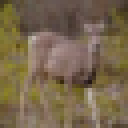

Image predicted as deer with confidence 0.31
y_hat[airplane] = 0.00
y_hat[automobile] = 0.00
y_hat[bird] = 0.19
y_hat[cat] = 0.08
y_hat[deer] = 0.31
y_hat[dog] = 0.05
y_hat[frog] = 0.26
y_hat[horse] = 0.11
y_hat[ship] = 0.00
y_hat[truck] = 0.00
Image 8490


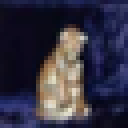

Image predicted as dog with confidence 0.48
y_hat[airplane] = 0.00
y_hat[automobile] = 0.00
y_hat[bird] = 0.05
y_hat[cat] = 0.38
y_hat[deer] = 0.01
y_hat[dog] = 0.48
y_hat[frog] = 0.03
y_hat[horse] = 0.05
y_hat[ship] = 0.00
y_hat[truck] = 0.00
Image 2785


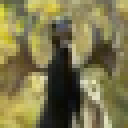

Image predicted as bird with confidence 0.63
y_hat[airplane] = 0.00
y_hat[automobile] = 0.00
y_hat[bird] = 0.63
y_hat[cat] = 0.07
y_hat[deer] = 0.13
y_hat[dog] = 0.13
y_hat[frog] = 0.02
y_hat[horse] = 0.01
y_hat[ship] = 0.00
y_hat[truck] = 0.00
Image 6480


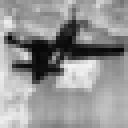

Image predicted as airplane with confidence 0.81
y_hat[airplane] = 0.81
y_hat[automobile] = 0.01
y_hat[bird] = 0.05
y_hat[cat] = 0.05
y_hat[deer] = 0.04
y_hat[dog] = 0.01
y_hat[frog] = 0.00
y_hat[horse] = 0.01
y_hat[ship] = 0.01
y_hat[truck] = 0.00
Image 4935


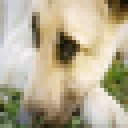

Image predicted as dog with confidence 0.56
y_hat[airplane] = 0.00
y_hat[automobile] = 0.00
y_hat[bird] = 0.21
y_hat[cat] = 0.22
y_hat[deer] = 0.01
y_hat[dog] = 0.56
y_hat[frog] = 0.00
y_hat[horse] = 0.00
y_hat[ship] = 0.00
y_hat[truck] = 0.00


In [47]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
un_normalize = lab_utils.UnNormalize((0.4914, 0.4822, 0.4465), 
                                     (0.2023, 0.1994, 0.2010))

network.eval()  # Important!

# Now predict the category using this trained classifier
for i in range(0, 5):
    img_id = random.randint(0, 10000)
    print('Image %d' % img_id)
    img, _ = valset[img_id]
    predictions = F.softmax(network(Variable(img.unsqueeze(0))))
    predictions = predictions.data

    # Show the results of the classifier.
    lab_utils.show_image(lab_utils.tensor2pil(un_normalize(img)).resize((128, 128)));
    max_score, max_label = predictions.max(1)
    print('Image predicted as %s with confidence %.2f' % (classes[max_label[0]], max_score[0]))

    # Print out detailed predictions.
    for (i, pred) in enumerate(predictions.squeeze().tolist()):
        print('y_hat[%s] = %.2f' % (classes[i], pred))

### 7. Pytorch's pretrained Convolutional Neural Networks.
Pytorch has several pretrained Convnet models in the Imagenet Large Scale Visual Recognition Challenge (ILSVRC) dataset. The ILSVRC task contains more than 1 million images in the training set, and the number of labels is 1000. Training a Convnet on this dataset takes often weeks on arrays of GPUs. Let's load one of such networks with 18 layers of depth, and try it in some images. Look below at how impressive is this neural network with so many layers and groups of layers, however most layers are still ReLU, Conv2d, and BatchNorm2d, with a few MaxPool2d, and one AvgPool2d and Linear at the end. There are also Resnet versions of depth size 34, 50, 101, and 152.

In [32]:
resnet = models.resnet18(pretrained = True)
print(resnet)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

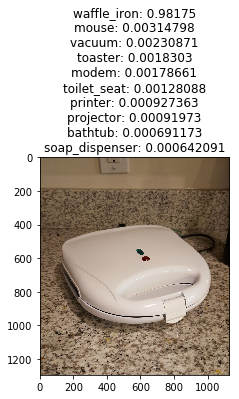

In [33]:
# 1. Define the appropriate image pre-processing function.
preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('imagenet_class_index.json')).items()}

# 3. Forward a test image of the toaster.
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()
# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('test_image.jpg').convert('RGB')
# Try your own image here. This is a picture of my toaster at home.
inputVar =  Variable(preprocessFn(image).unsqueeze(0))
predictions = resnet(inputVar)

# 4. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions)).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
plt.title(string.join(preds, '\n'))
plt.imshow(image);

### 8. Fine-tuning Resnet on CIFAR-10

We will now use a pretrained network known as Alexnet on CIFAR-10 data, however there is a problem which is that Alexnet takes images in 224x224 resolution, and CIFAR-10 images are 32x32. So we will scale-up images in CIFAR-10 so that they work with Alexnet.


In [ ]:
# Same transformations as before but we do not vectorize the images.
# Additionally we are scaling up images to 224x224 in order to use Resnet.
imgTransform = transforms.Compose([transforms.Scale((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010))])
trainset = CIFAR10(root='./data', train = True, transform = imgTransform)
valset = CIFAR10(root='./data', train = False, transform = imgTransform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 64, 
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 64, 
                                        shuffle = False, num_workers = 0)

The code below will be extremely slow on a CPU, hours per epoch, and maybe a week to finish all epochs. For this part yu will need GPU nodes in the cloud (AWS, Google Cloud) or your own GPU. Another thing, is that GPUs do not have a lot of memory so batch size 128 is also not going to be possible.

In [ ]:
from tqdm import tqdm_notebook as tqdm

learningRate = 1e-3  # Single learning rate for this lab.

# Definition of our network.
network = models.alexnet(pretrained = True)
network.fc = nn.Linear(2048, 10)  # CIFAR-10 has 10 classes not 1000.

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

#Scheduler
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[4,8,12,16],gamma=0.3);

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

def train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        
        scheduler.step()
        
        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            counter += inputs.size(0)
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            counter += inputs.size(0)
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)   
            
# Train the previously defined model.
train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

## Lab Questions (10pts)

1) [2pts] In section 3 of this lab we implemented the ReLU activation function, and used it to train a two-layer neural network. Here please implement Sigmoid, and TanH:

$$\text{Sigmoid(x)} = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}$$

$$\text{Tanh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

In [ ]:
# Sigmoid of x.
class nn_Sigmoid:
    def forward(self, x):
        numerator = torch.exp(x)                # e^x
        denominator = torch.add(numerator,1)    # e^x + 1
        return torch.div(numerator,denominator) # (e^x) / (e^x + 1)
        
    def backward(self, x, gradOutput):
        gradInput = gradOutput.clone()
        numerator = torch.exp(x)                        # e^x
        denominator = torch.add(numerator,1)            # e^x + 1
        denominator = torch.pow(denominator,2)          # (e^x + 1)^2
        gradOutput = torch.div(numerator,denominator)   # (e^x) / (e^x + 1)^2
        return torch.mul(gradInput,gradOutput)
      
# Hyperbolic tangent.
class nn_Tanh:
    def forward(self, x):
        return torch.tanh(x)                            # tanh(x)
    
    def backward(self, x, gradOutput):
        gradInput = gradOutput.clone()
        tanh = torch.tanh(x)                            # tanh(x)
        gradOutput = torch.add(-torch.pow(tanh,2),1)    # 1 - tanh(x)^2
        return torch.mul(gradOutput,gradInput)

2) [1pts] Our ReLU function makes things zero when they are less than zero. This is still the most widely used activation function used today but a variante called LeakyReLU has been proposed where a linear function close to zero is used instead. Here is the definition:

$$ \text{LeakyReLU}(x) = \begin{cases} 
      \beta x & x < 0 \\
      x & x \geq 0 
\end{cases}$$

where $\beta$ is usally a small value e.g. $\beta = 0.3$

In [ ]:
# Leaky ReLU.
class nn_LeakyReLU:
    def __init__(self, beta = 0.3):
        self.beta = beta
    
    def forward(self, x):
        # Forward pass.
        output = x.clone()
        output[output < 0] *= self.beta
        return output
    
    def backward(self, x, gradOutput):
        # Backward pass
        gradInput = gradOutput.clone()
        gradInput[x < 0] *= self.beta
        return gradInput

3) [3pts] Propose a new convolutional neural network that obtains at least 76% accuracy in the CIFAR-10 validation set. Show here the code for your network, and a plot showing the training accuracy, validation accuracy, and another one with the training loss, and validation loss (similar plots as in our previous lab). Included is below the LeNet implementation that you can use as a starting point.

#### Training and Validation Plots

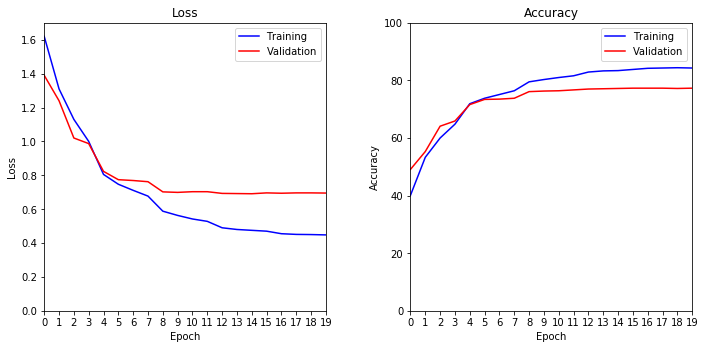

In [21]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],[1.62,1.31,1.13,1,.805,.747,.711,.677,.588,.563,.542,.528,.49,.48,.475,.47,.455,.451,.45,.448],'b-',label='Training')
plt.subplot(121)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],[1.39,1.24,1.02,.987,.823,.774,.769,.762,.702,.699,.703,.703,.693,.692,.691,.696,.694,.696,.696,.695],'r-',label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.axis([0,19,0,1.7])
plt.legend()

plt.subplot(122)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],[40.1,53.3,60,64.8,71.9,73.8,75.1,76.4,79.5,80.3,81,81.6,82.9,83.3,83.4,83.8,84.2,84.3,84.4,84.3],'b-',label='Training')
plt.subplot(122)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],[49.1,55.3,64.1,65.9,71.6,73.4,73.5,73.8,76.1,76.3,76.4,76.7,77,77.1,77.2,77.3,77.3,77.3,77.2,77.3],'r-',label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.axis([0,19,0,100])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.subplots_adjust(top=1, bottom=0, left=0, right=1.5, hspace=0.35, wspace=0.3)
plt.legend()
plt.show()

#### Network Definition

In [ ]:
from tqdm import tqdm_notebook as tqdm

# Note:  added "scheduler" argument to train_model() to support adaptive learning rate
learningRate = 7e-3

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        # Convolutional layers.                                                                                                       
        self.conv1 = nn.Conv2d(3, 6, 5)                      
        self.conv2 = nn.Conv2d(6, 10, 3, padding=1)       
        self.conv3 = nn.Conv2d(10, 32, 3)               
        self.conv4 = nn.Conv2d(32, 48, 3, padding=1)
        self.conv5 = nn.Conv2d(48, 54, 3, padding=1)
        self.conv6 = nn.Conv2d(54, 64, 3, padding=1)
        self.conv7 = nn.Conv2d(64, 80, 3, padding=1)
        self.conv8 = nn.Conv2d(80, 96, 3, padding=1)
        # Linear layers.                                                                                                              
        self.fc1 = nn.Linear(96*3*3, 360)
        self.fc2 = nn.Linear(360, 120)
        self.fc3 = nn.Linear(120, 10)
        # Other layers                                                                                                                
        self.lnsft = nn.LogSoftmax()
        self.bnorm1 = nn.BatchNorm2d(48)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.drop = nn.Dropout2d(0.3)
        self.amp0 = nn.AdaptiveMaxPool2d(14)
        self.amp1 = nn.AdaptiveMaxPool2d(6)
        self.amp2 = nn.AdaptiveMaxPool2d(3)
        
    def forward(self, x):                                                                                                     
        out = F.elu(self.conv1(x))    # output 6x28x28                                                                                
        out = F.elu(self.conv2(out))  # output 10x28x28                                                                               
        out = self.amp0(out)          # output 10x14x14                                                                               
        out = F.elu(self.conv3(out))  # output 32x12x12                                                                               
        out = F.elu(self.conv4(out))  # output 48x12x12                                                                               
        out = self.amp1(out)          # output 48x6x6                                                                                 
        out = self.drop(out)          # prevent overtraining                                                                          
        out = self.bnorm1(out)        # normalization                                                                                 
        out = F.elu(self.conv5(out))  # output 54x6x6                                                                                 
        out = F.elu(self.conv6(out))  # output 64x6x6                                                                                 
        out = self.amp2(out)          # output 64x3x3                                                                                                                                                              
        out = F.elu(self.conv7(out))  # output 80x3x3                                                                                 
        out = F.elu(self.conv8(out))  # output 96x3x3                                                                                 
        out = self.amp2(out)          # output 96x3x3                                                                                 
        out = out.view(out.size(0), -1)
        out = F.elu(self.fc1(out))
        out = F.elu(self.fc2(out))
        out = self.fc3(out)
        out = self.lnsft(out)
        return out
                                                                                                         
network = MyNetwork()
# Loss                                                                                            
criterion = nn.NLLLoss()
# Optimizer                                  
optimizer = optim.Adamax(network.parameters(), lr = learningRate, weight_decay=0.001)
# Learning Rate Scheduling                                                                                                                      
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[4,8,12,16],gamma=0.3);
# Train the model                                                                                               
train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 20, use_gpu = True)

4) [4pts] Train a Convolutional Neural Network on the Dogs vs Cats Kaggle competition dataset https://www.kaggle.com/c/dogs-vs-cats. The training data has 25,000 images, I already separated the images into training: 20,000 images and validation: 5,000 images. So please download the training, validation splits from the following dropbox link instead: [cats_dogs.zip](https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip?dl=0), or CS link: [cat_dogs.zip](http://www.cs.virginia.edu/~vicente/recognition/notebooks/cats_dogs.zip) . You will have to write your own dataset class inheriting from torch.utils.data.Dataset, and a model that trains on this dataset. As usual, include plots.

##### See Optional 1 below -- fine-tuned Resnet18 on the cats_dogs data for Question 4

### Optional

1) [3pts] For Q4 you get extra points if you use Resnet as in Section 7 but replace the fc layer at the end so that the model only predicts two variables (cat and dog). You will have to then re-train Resnet in this dataset. The idea is to use a model that has already been pre-trained on large task (ILSVRC), and re-train it (often called fine-tuning), on a smaller dataset. Present your code for the model, training output, plots, and example classifications on a few validations set images. Note: If you provide a model that does this in Q4, you directly get awarded 7pts in Q4 but for clarity provide the solution here instead if you plan to do this. Keep in mind that re-training Resnet on 20,000 images will probably still require GPU computing, and some significant computing time so start this early.

#### Dataset and Network Definition

In [10]:
# I split the trainset and valset into two subfolders "cat" and "dog"  i.e. cats_dogs/trainset/cats and cats_dogs/trainset/dogs, etc
# This allowed me to use pytorch's ImageFolder method to use the directory name as the class label.
# Reference:  http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = {
    'trainset': transforms.Compose([transforms.Scale((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                                         (0.229, 0.224, 0.225))]),
    'valset': transforms.Compose([transforms.Scale((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), 
                                                       (0.229, 0.224, 0.225))])}
data_dir = 'cats_dogs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['trainset', 'valset']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['trainset', 'valset']}
class_names = image_datasets['trainset'].classes
trainLoader = torch.utils.data.DataLoader(image_datasets['trainset'], batch_size = 64, shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(image_datasets['valset'], batch_size = 64, shuffle = False, num_workers = 0)    
    
        
# Definition of our network.
network = models.resnet18(pretrained = True)
network.fc = nn.Linear(512,2)
network.train()
learningRate = 1e-3 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(network.parameters(), lr = learningRate, weight_decay = 0.001)
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[4,7,8],gamma=0.4);
train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

#### Training Output
(included as image here due to issue with widgets downloaded from AWS notebook server)

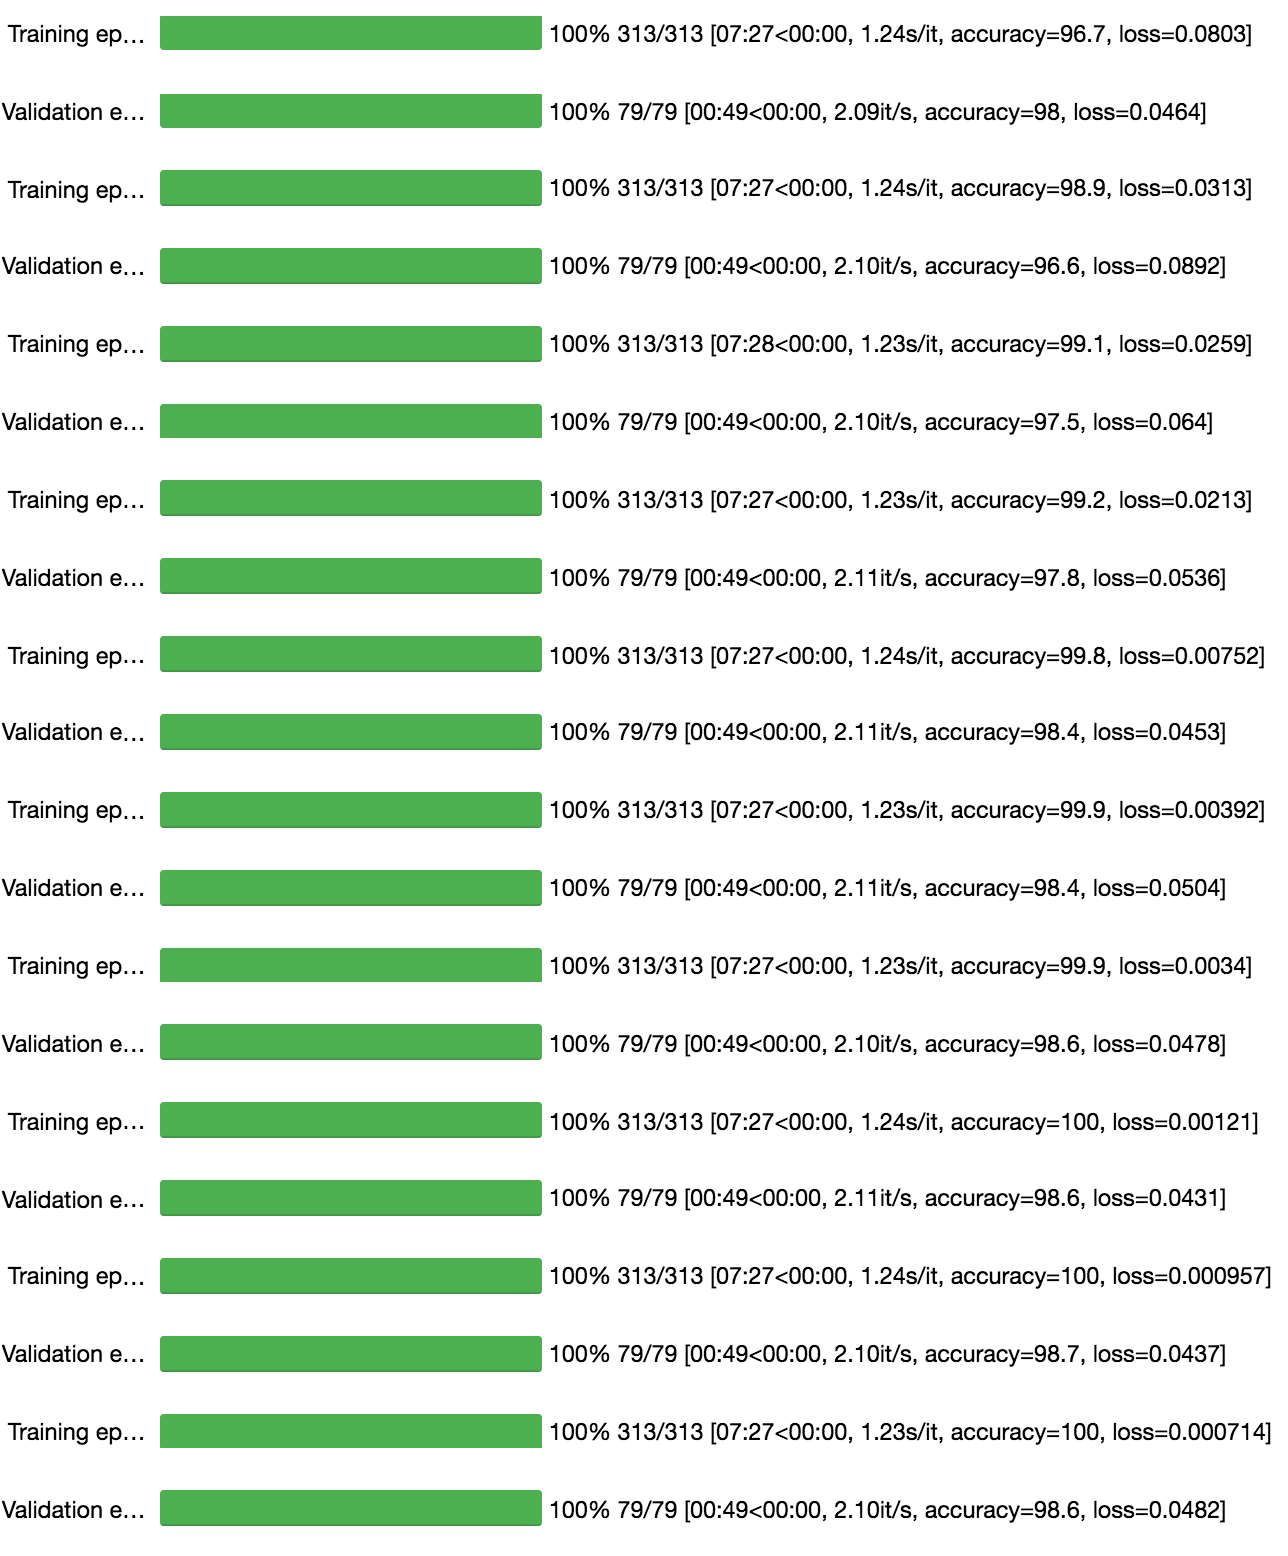

#### Example Classifications


Image 749


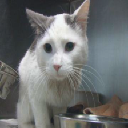

Image predicted as cats with confidence 1.00
y_hat[cats] = 1.00
y_hat[dogs] = 0.00

Image 4861


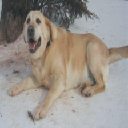

Image predicted as dogs with confidence 1.00
y_hat[cats] = 0.00
y_hat[dogs] = 1.00

Image 1141


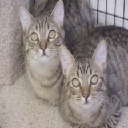

Image predicted as cats with confidence 1.00
y_hat[cats] = 1.00
y_hat[dogs] = 0.00

Image 2719


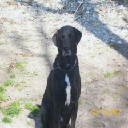

Image predicted as dogs with confidence 1.00
y_hat[cats] = 0.00
y_hat[dogs] = 1.00

Image 4047


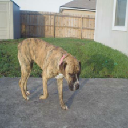

Image predicted as dogs with confidence 1.00
y_hat[cats] = 0.00
y_hat[dogs] = 1.00


In [29]:
# Randomly select 5 images from the validation set
network.eval()

# Import class names (from dataloader, above)
classes = class_names

# Now predict the category using this trained classifier
for i in range(0, 5):
    img_id = random.randint(0, 5000) # 5000 images in this validation set
    print('\nImage %d' % img_id)
    img, _ = image_datasets['valset'][img_id]
    predictions = F.softmax(network(Variable(img.unsqueeze(0)).cuda()))
    predictions = predictions.data

    # Show the results of the classifier.
    lab_utils.show_image(lab_utils.tensor2pil(un_normalize(img)).resize((128, 128)));
    max_score, max_label = predictions.max(1)
    print('Image predicted as %s with confidence %.2f' % (classes[max_label[0]], max_score[0]))

    # Print out detailed predictions.
    for (i, pred) in enumerate(predictions.squeeze().tolist()):
        print('y_hat[%s] = %.2f' % (classes[i], pred))

#### Training and Validation Plots

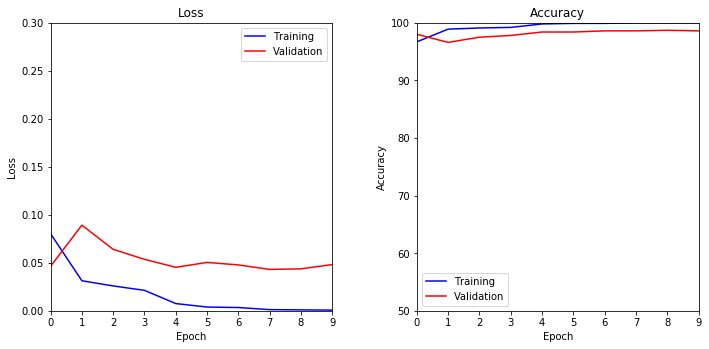

In [6]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot([0,1,2,3,4,5,6,7,8,9],[.0803,.0313,.0259,.0213,.00752,.00392,.0034,.00121,.000957,.000714],'b-',label='Training')
plt.subplot(121)
plt.plot([0,1,2,3,4,5,6,7,8,9],[.0464,.0892,.064,.0536,.0453,.0504,.0478,.0431,.0437,.0482],'r-',label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.axis([0,9,0,.3])
plt.legend()
plt.subplot(122)
plt.plot([0,1,2,3,4,5,6,7,8,9],[96.7,98.9,99.1,99.2,99.8,99.9,99.9,100,100,100],'b-',label='Training')
plt.subplot(122)
plt.plot([0,1,2,3,4,5,6,7,8,9],[98,96.6,97.5,97.8,98.4,98.4,98.6,98.6,98.7,98.6],'r-',label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.axis([0,9,50,100])
plt.subplots_adjust(top=1, bottom=0, left=0, right=1.5, hspace=0.35, wspace=0.3)
plt.legend()
plt.show()

2) [2pts] A simpler (less time consuming) approach to using a pre-trained CNN is to use it as a feature extractor. In this strategy we would use the Resnet network to compute "features" of the images, and then train a simple softmax classifier on top of those features. We could for instance remove the "fc" layer from the model, and use the 512-dimensional output of the network as our "features" for each image. Then we train a softmax classifier using these 512-dimensional vectors as inputs. Train such a classifier here for the dogs vs cats task, and present model, plots, and a few example classifications on the validation set. Note: In this task, since we only run the forward pass of Resnet once for each image, we might be able to get away doing this optional part without a GPU.

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>